In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from datetime import datetime
from sklearn.model_selection import cross_val_score


In [2]:
data = pd.read_csv('./features.csv', index_col='match_id')

features_orig = data.drop( labels=['duration','radiant_win','tower_status_radiant', 'tower_status_dire',
       'barracks_status_radiant', 'barracks_status_dire'],axis=1)
empty_count = features_orig.shape[0] - features_orig.count()
features_with_missing_values = list(empty_count[empty_count != 0].keys())
features = features_orig.fillna(0)
# features = pd.DataFrame(PCA(50).fit_transform(features))

In [209]:
n_splits = 5
cv = KFold(n_splits=n_splits,shuffle=True)

scores = list()
train_times = list()
trees_list = np.arange(1,5)*10
for i in trees_list:
    clf = GradientBoostingClassifier(n_estimators=i)
    start = datetime.now()
    score=cross_val_score(clf, features, data.radiant_win, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    delta = (datetime.now() - start).seconds
    train_times.append(delta)
    print(f'Tree count: {i}; Mean train score: {score}; Time {delta} seconds')
    
best_tree_number = trees_list[np.array(scores).argmax()]
print('Лучшее число деревьев: ',best_tree_number)
print('Score : ',np.array(scores).max()  )

Tree count: 10; Mean train score: 0.6644189331930598; Time 23 seconds
Tree count: 20; Mean train score: 0.6811892035389311; Time 42 seconds
Tree count: 30; Mean train score: 0.6890142608006791; Time 64 seconds
Tree count: 40; Mean train score: 0.6945354868975804; Time 83 seconds
Лучшее число деревьев:  40
Validation score :  0.694535486898


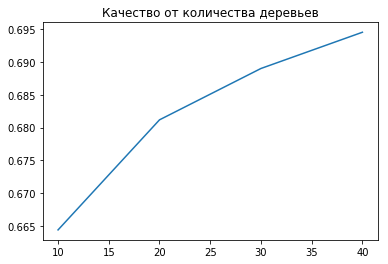

In [210]:
plt.title('Качество от количества деревьев')
plt.plot(trees_list,scores)



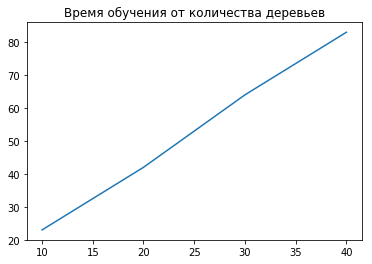

In [211]:
plt.title('Время обучения от количества деревьев')
plt.plot(trees_list,train_times)


### Подход 1: градиентный бустинг "в лоб". Отчёт

1. В 12 признаках есть пропуски, к примеру: first_blood_time, radiant_bottle_time, если событие "первая кровь" не произошло или предмет bottle не был приобретён. Ниже список признаков с пропусками:

 'first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time'
 
2. Целевую переменную содержит столбец **radiant_win**
3. ROC-AUC при 30 деревьях: 0.6364, 

    время обучения: 89 секунд
    
4. При увеличении числа деревьев растет качество на обучающей и тестовой выборках, при этом рост замедляется, тогда как время обучения линейно растёт. 
        
      Для ускорения обучения можно :
      * Задать меньшую глубину деревьям
      * Уменьшить количество признаков с помощью метода главных компонент
      

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [11]:
def run_regression(features):
    features = pd.DataFrame(StandardScaler().fit_transform(features.fillna(0)))


    n_splits = 5
    cv = KFold(n_splits=n_splits,shuffle=True)

    
    scores = list()
    train_times = list()
    
#     c_list = np.logspace(0.001,1000,10)
#     c_list = [0.01,1,100]
    c_list = np.power(10,np.arange(-5.,6))
    for i in c_list:
        clf = LogisticRegression(C=i)
        start = datetime.now()
        score=cross_val_score(clf, features, data.radiant_win, cv=cv, scoring='roc_auc').mean()
        delta = (datetime.now() - start).seconds
        train_times.append(delta)
        scores.append(score)
        
        print(f'C: {i}; Mean train score: {score}; Time {delta} seconds')



    best_reg_param = c_list[np.array(scores).argmax()]
    print('Лучший коэффициент регуляризации: ',best_reg_param)
    print('Score : ',np.array(scores).max())
    
    plt.title('Качество от параметра регуляризации')
    plt.semilogx(c_list,scores)

    
    


C: 1e-05; Mean train score: 0.6950458164225779; Time 2 seconds
C: 0.0001; Mean train score: 0.7113277896602277; Time 4 seconds
C: 0.001; Mean train score: 0.7163686639617547; Time 7 seconds
C: 0.01; Mean train score: 0.7163552703196421; Time 9 seconds
C: 0.1; Mean train score: 0.7162574771120231; Time 10 seconds
C: 1.0; Mean train score: 0.7163662252119514; Time 10 seconds
C: 10.0; Mean train score: 0.716390884849391; Time 10 seconds
C: 100.0; Mean train score: 0.7164592144827256; Time 10 seconds
C: 1000.0; Mean train score: 0.716251438978994; Time 10 seconds
C: 10000.0; Mean train score: 0.7164650059309474; Time 10 seconds
C: 100000.0; Mean train score: 0.7163575276317472; Time 10 seconds
Лучший коэффициент регуляризации:  10000.0
Score :  0.716465005931


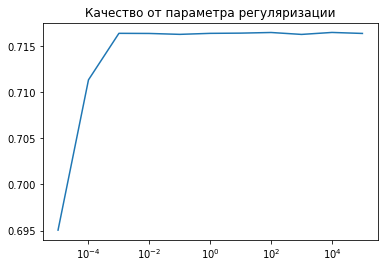

In [12]:
run_regression(features_orig)

C: 1e-05; Mean train score: 0.6949508259284677; Time 2 seconds
C: 0.0001; Mean train score: 0.7112493662223176; Time 4 seconds
C: 0.001; Mean train score: 0.7162305313339309; Time 7 seconds
C: 0.01; Mean train score: 0.716389588653298; Time 9 seconds
C: 0.1; Mean train score: 0.7164211424144658; Time 9 seconds
C: 1.0; Mean train score: 0.716652813241258; Time 10 seconds
C: 10.0; Mean train score: 0.7161977890228343; Time 10 seconds
C: 100.0; Mean train score: 0.7163639707463128; Time 10 seconds
C: 1000.0; Mean train score: 0.7164389495136568; Time 10 seconds
C: 10000.0; Mean train score: 0.7164335313884739; Time 10 seconds
C: 100000.0; Mean train score: 0.7164835068682314; Time 9 seconds
Лучший коэффициент регуляризации:  1.0
Score :  0.716652813241


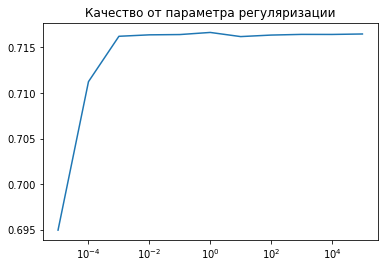

In [13]:
scores = no_cat_features = features_orig.drop(['lobby_type',
 'r1_hero',
 'r2_hero',
 'r3_hero',
 'r4_hero',
 'r5_hero',
 'd1_hero',
 'd2_hero',
 'd3_hero',
 'd4_hero',
 'd5_hero'], axis=1)

run_regression(no_cat_features)

In [14]:
0.716465005931-0.716652813241

-0.00018780731000000994